### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

Some parameters

In [2]:
data_dir = pathlib.Path('/home/henrik/master_thesis/data/kvasir-dataset-v2/')

image_count = len(list(data_dir.glob('*/*.jpg')))
print (image_count)

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

8000


In [3]:
class_names = np.array([item.name for item in data_dir.glob('*') if item.name != '*.txt'])
class_names

array(['normal-cecum', 'ulcerative-colitis', 'dyed-resection-margins',
       'polyps', 'dyed-lifted-polyps', 'esophagitis', 'normal-pylorus',
       'normal-z-line'], dtype='<U22')

### Loading images with `tf.data.Dataset`.

In [4]:
# Create a dataset of the file paths
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))

for path in list_ds.take(5):
    print(path.numpy())

b'/home/henrik/master_thesis/data/kvasir-dataset-v2/polyps/c9cde631-d542-46c8-90d6-bb399e0e5e80.jpg'
b'/home/henrik/master_thesis/data/kvasir-dataset-v2/dyed-lifted-polyps/bc863451-6219-4ce4-90ca-1c853c54c7d5.jpg'
b'/home/henrik/master_thesis/data/kvasir-dataset-v2/normal-z-line/4036ad5e-ff32-41cc-bd28-3eafcfeae2bc.jpg'
b'/home/henrik/master_thesis/data/kvasir-dataset-v2/normal-pylorus/5c1e245c-c69e-42e5-a5b3-fcfba78b667f.jpg'
b'/home/henrik/master_thesis/data/kvasir-dataset-v2/ulcerative-colitis/570bd6dd-2e70-4725-9fa0-da78d086b304.jpg'


A short pure-tensorflow function that converts a file path to an `image_data, label` pair:

In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == class_names

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Using `Dataset.map` to create a dataset of `Image, label` pairs:

In [6]:
# Set 'num_parallel_calls' so multiple images are loaded and processed in parallel
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [7]:
for image, label in labeled_ds.take(1):
    print ('Image shape: ', image.numpy().shape)
    print ('Label: ', label.numpy())

Image shape:  (224, 224, 3)
Label:  [False False False False False False False  True]


### Prepare dataset for training
Want the data to be shuffled and batched. Here we use the `tf.data` api.

In [8]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
      if isinstance(cache, str):
        ds = ds.cache(cache)
      else:
        ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [9]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(class_names[label_batch[n]==1][0].title())
        plt.axis('off')

In [10]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

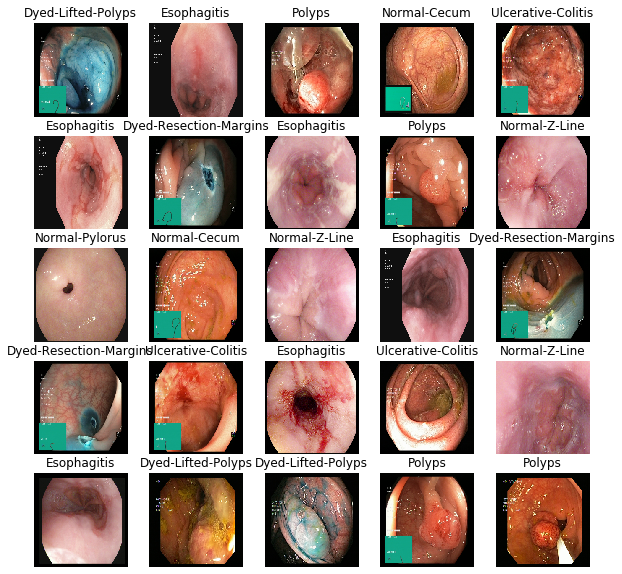

In [11]:
show_batch(image_batch.numpy(), label_batch.numpy())

In [12]:
import time
default_timeit_steps = 100

def timeit(ds, steps=default_timeit_steps):
  start = time.time()
  it = iter(ds)
  for i in range(steps):
    batch = next(it)
    if i%10 == 0:
      print('.',end='')
  print()
  end = time.time()

  duration = end-start
  print("{} batches: {} s".format(steps, duration))
  print("{:0.5f} Images/s".format(BATCH_SIZE*steps/duration))

In [13]:
# Prepare dataset with cache
timeit(train_ds)

..........
100 batches: 16.219032526016235 s
197.29907 Images/s


In [14]:
# Prepare dataset without cahce
uncached_ds = prepare_for_training(labeled_ds, cache=False)
timeit(uncached_ds)

..........
100 batches: 16.650693655014038 s
192.18419 Images/s


In [15]:
# Prepare dataset with chache file (in case ds dont fit in memory)
filecache_ds = prepare_for_training(labeled_ds, cache="./kvasir_ds.tfcache")
timeit(filecache_ds)

..........
100 batches: 18.671720266342163 s
171.38217 Images/s
